In [186]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor # 랜덤포레스트 회귀모델
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder

#### 아파트 데이터, 금리 데이터, 학교 데이터, 지하철 주소 데이터를 통합하며 데이터 전처리와 pandas를 확실히 익힌다.

1. 데이터를 가져오고 형태를 파악한다.

In [187]:
# 데이터 불러오기

apart_df = pd.read_csv("../data/20250605_102903_seoul_real_estate.csv")
interest_rate_df = pd.read_csv("../data/deposit_lending_rate.csv")
shcool_df = pd.read_csv("../data/seoul_shcool_info.csv")
subway_df = pd.read_csv("../data/seoul_subway_encoding.csv")

In [188]:
# 지하철 컬럼명 변경 및 불필요 컬럼 제거
subway_df.drop(columns=['Unnamed: 0', '역번호', '연번', '역전화번호', '도로명주소'], axis=1, inplace=True) # 컬럼명 없는 컬럼 삭제
subway_df.rename(columns={'호선' : 'line_num', '역명' : 'station_name', '지번주소' : 'address'}, inplace=True)

In [189]:
# 지하철 주소 컬럼 시.구분리, 기존 주소컬럼 제거
subway_df['gu'] = subway_df['address'].str.extract(r'(\S+구)')
subway_df['dong'] = subway_df['address'].str.extract(r'(\S+(?:동|가|로))')
subway_df.drop(columns=['address','dong'], inplace=True)
subway_df['station_name'] = subway_df['station_name'] + '역'
subway_df.columns

Index(['line_num', 'station_name', 'gu'], dtype='object')

In [190]:
# 학교 주소 컬럼 시,구분리, 기존 주소컬럼 제거
shcool_df['gu'] = shcool_df['address'].str.extract(r'(\S+구)')
shcool_df.drop(columns=['address'], inplace=True)
shcool_df.columns

Index(['school_type', 'type', 'school_name', 'high_school_type', 'gu'], dtype='object')

In [191]:
# 금리데이터 이름 변경
interest_rate_df.rename(columns={'Unnamed: 0':'date'}, inplace=True)

In [192]:
# 금리 데이터 날짜 분리, 날짜 및 잘못 추가된 컬럼 제거
interest_rate_df['year'] = interest_rate_df['date'].str.split('-').str[0].astype(int)
interest_rate_df['month'] = interest_rate_df['date'].str.split('-').str[1].astype(int)
interest_rate_df.drop(columns=['date', 'Unnamed: 4'], inplace=True)
interest_rate_df

,landing,deposit,diff,year,month
0,11.43,10.42,1.01,1996,1
1,11.47,10.26,1.21,1996,2
2,11.37,10.33,1.04,1996,3
3,11.11,9.88,1.23,1996,4
4,11.24,9.62,1.62,1996,5
...,...,...,...,...,...
349,4.46,2.97,1.49,2025,2
350,4.36,2.84,1.52,2025,3
351,4.19,2.71,1.48,2025,4
352,4.19,2.96,1.23,2025,5


In [193]:
# 데이터 셋 날짜 분리

# CTRT_DAY를 날짜 타입으로 변환
apart_df['CTRT_DAY'] = pd.to_datetime(apart_df['CTRT_DAY'])

# 연, 월로 분리해서 새로운 컬럼 만들기
apart_df['CTRT_YEAR'] = apart_df['CTRT_DAY'].dt.year
apart_df['CTRT_MONTH'] = apart_df['CTRT_DAY'].dt.month

In [194]:
# 아파트 주소'구'를 이용해 지하철 역, 학교(초중고) 병합
subway_gu = subway_df.groupby('gu').first().reset_index()

apart_df = apart_df.merge(subway_gu[['line_num', 'station_name', 'gu']], right_on='gu', left_on='CGG_NM', how='left')

shcool_gu = shcool_df.groupby('gu').first().reset_index()
apart_df = apart_df.merge(shcool_gu[['school_type', 'gu']], right_on='gu', left_on='CGG_NM', how='left')


apart_df = apart_df.merge(
    interest_rate_df[['year', 'month', 'landing', 'deposit']],
    left_on=['CTRT_YEAR', 'CTRT_MONTH'],
    right_on=['year', 'month'],
    how='left'
)

In [195]:
# 중복 컬럼 제거 (지하철 gu, 학교 gu, 금리(year, mont))
new_df = apart_df.copy()

new_df.drop(columns=['gu_x', 'gu_y', 'year', 'month'], inplace=True)

In [196]:
new_df.drop(columns=["CGG_CD", "STDG_CD", "LOTNO_SE", "BLDG_NM", "LOTNO_SE_NM", 'CTRT_DAY', 'RTRCN_DAY', 'THING_AMT', 'RGHT_SE', 'OPBIZ_RESTAGNT_SGG_NM', 'LAND_AREA'], inplace=True)
new_df.columns

Index(['RCPT_YR', 'CGG_NM', 'STDG_NM', 'MNO', 'SNO', 'ARCH_AREA', 'FLR',
       'ARCH_YR', 'BLDG_USG', 'DCLR_SE', 'ARCH_DECADE', 'PYEONG',
       'PYEONG_GROUP', 'PRICE_EUK', 'PRICE_PER_PYEONG', 'CTRT_YEAR',
       'CTRT_MONTH', 'line_num', 'station_name', 'school_type', 'landing',
       'deposit'],
      dtype='object')

In [ ]:
# 추가 전처리

# 속성 이름의 명확성 정리
rename_cols = [
    'receipt_year',
    'gu_name',
    'dong_name',
    'main_lot_num',
    'sub_lot_num',
    'arch_area',
    'floor',
    'arch_year',
    'building_usage',
    'deal_type',
    'arch_decade',
    'pyeong',
    'pyeong_group',
    'price_euk',
    'price_per_pyeong',
    'contract_year',
    'contract_month',
    'subway_line',
    'subway_name',
    'school_type',
    'landing_rate',
    'deposit_rate'
]

new_df.columns = rename_cols

In [198]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136672 entries, 0 to 136671
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   receipt_year      136672 non-null  int64  
 1   gu_name           136671 non-null  object 
 2   dong_name         136672 non-null  object 
 3   main_lot_num      136665 non-null  float64
 4   sub_lot_num       136665 non-null  float64
 5   arch_area         136672 non-null  float64
 6   floor             136672 non-null  int64  
 7   arch_year         136667 non-null  float64
 8   building_usage    136672 non-null  object 
 9   deal_type         136591 non-null  object 
 10  arch_decade       136672 non-null  object 
 11  pyeong            136672 non-null  float64
 12  pyeong_group      136672 non-null  object 
 13  price_euk         136672 non-null  float64
 14  price_per_pyeong  136672 non-null  float64
 15  contract_year     136672 non-null  int32  
 16  contract_month    13

In [200]:
# 아파트 데이터 문자열 > 숫자로
# 숫자로 바꿔야 할 컬럼 리스트
str_columns = [
    'gu_name', 'dong_name', 'building_usage', 'deal_type', 'arch_decade', 'pyeong_group', 'subway_name', 'school_type'
]

# LabelEncoder로 문자열을 숫자로 변환
for col in str_columns:
    le = LabelEncoder()
    new_df[col] = le.fit_transform(new_df[col].astype(str))

In [203]:
new_df.isnull().sum()

receipt_year        0
gu_name             0
dong_name           0
main_lot_num        7
sub_lot_num         7
arch_area           0
floor               0
arch_year           5
building_usage      0
deal_type           0
arch_decade         0
pyeong              0
pyeong_group        0
price_euk           0
price_per_pyeong    0
contract_year       0
contract_month      0
subway_line         1
subway_name         0
school_type         0
landing_rate        0
deposit_rate        0
dtype: int64

In [205]:
# 결측치 제거
new_df.dropna(subset=['main_lot_num', 'sub_lot_num', 'arch_year', 'subway_line'], inplace=True)

In [208]:
# 불필요 데이터 확인을 위한 모델 학습

X = new_df.drop('price_euk', axis=1)  # 입력 데이터(속성)
y = new_df['price_euk']               # 타겟(거래금액)

# 랜덤포레스트 모델 학습
model = RandomForestRegressor(random_state=0)
model.fit(X, y)

# 속성 중요도 가져오기
importances = model.feature_importances_
feature_names = X.columns

# 판다스 시리즈로 변환해서 정렬
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=True)

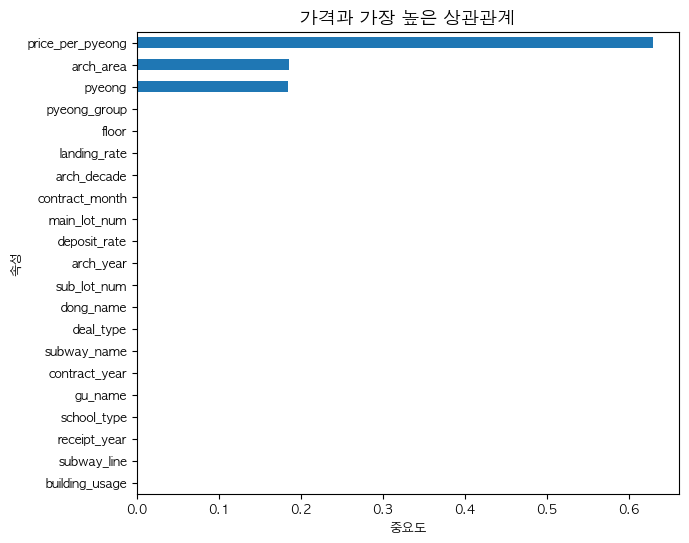

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# 1. 폰트 설정 (애플고딕, macOS)
plt.rcParams['font.family'] = 'AppleGothic'   # 한글 폰트
plt.rcParams['font.size'] = 9                 # 전체 폰트 크기
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 깨짐 방지

# 가로 막대그래프 그리기
plt.figure(figsize=(7, 6))
feat_importances.plot(kind='barh')  # barh: 가로 막대그래프
plt.title('가격과 가장 높은 상관관계', fontsize = 13)
plt.xlabel('중요도')
plt.ylabel('속성')
plt.gca().yaxis.set_major_locator(MultipleLocator())
plt.show()

In [ ]:
# 금리데이터(시중은행 평균 금리), 서울지하철역, 서울학교 병합 데이터
new_df.to_csv("../data/new_apart_data_preprocessing.csv")